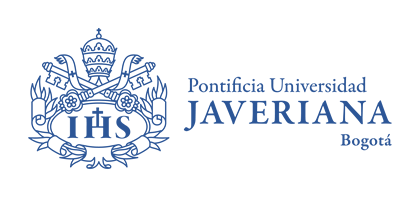

# Aprendizaje de máquina - Taller 2 - Redes neuronales artificiales
En este notebook vamos a explorar implementaciones de redes neuronales feedforward en usando la librería keras y se propone el enunciado del taller 2 del curso.

## Setup

Importaremos las librerías necesarias para el ejercicio

In [1]:
import pandas as pd
import numpy as np
from sklearn import pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from pathlib import Path


2025-10-18 22:12:34.316305: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-18 22:12:34.338869: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Redes neuronales artificiales feedforward

Las redes neuronales de alimentación hacia adelante son modelos de aprendizaje de máquina que conectan las unidades neuronales en capas. Estos modelos tienen una capa de entrada que recibe las instancias, una o más capas intermedias o capas ocultas, y una capa de salida o final que da la respuesta según el problema a resolver (regresión o clasificación). Las unidades neuronales de una capa reciben las activaciones de todas las unidades neuronales de la capa anterior y conectan su activación a todas las unidades neuronales de la capa siguiente.


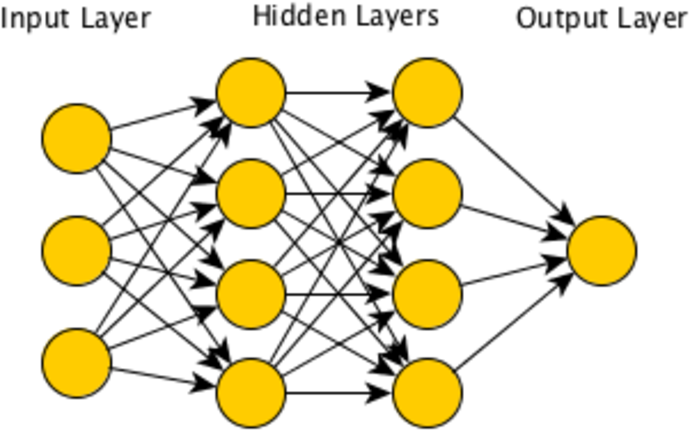

Las redes neuronales artificiales de alimentación hacia adelante son modeladores universales de funciones siempre y cuando se puedan añadir [suficientes unidades neuronales o suficientes capas](https://en.wikipedia.org/wiki/Universal_approximation_theorem)






## Ejercicio - Espirales

Ilustremos inicialmente el uso del modelo de clasificación de redes neuronales utilizando el ejemplo de las espirales que no eran separables por el perceptrón o ADALINE.




In [ ]:
N=1000

In [ ]:
def twospirals(n_points, noise=.5):
    """
     Returns the two spirals dataset.
    """
    n = np.sqrt(np.random.rand(n_points,1)) * 780 * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_points,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))),
            np.hstack((np.zeros(n_points),np.ones(n_points))))

X, y = twospirals(N)
y

array([0., 0., 0., ..., 1., 1., 1.])

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,y, test_size=0.20, random_state=42)

In [5]:
X_train.shape

(1600, 2)

In [6]:
X_test.shape

(400, 2)

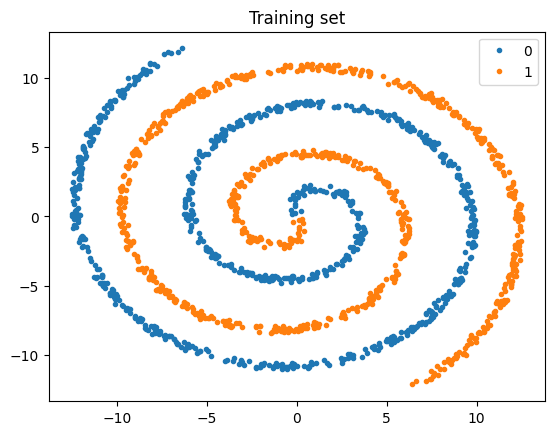

In [7]:
plt.title('Training set')
plt.plot(X_train[Y_train==0,0], X_train[Y_train==0,1], '.', label=0)
plt.plot(X_train[Y_train==1,0], X_train[Y_train==1,1], '.', label=1)
plt.legend()
plt.show()

### Partición datos en entrenamiento, validación y test

A continuación crearemos 3 datasets a partir del dataset no separable linealmente

In [8]:
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
X_val,X_test, y_val,y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

In [10]:
len(X_train)

1600

In [11]:
X_train

array([[-1.08639125,  7.97484176],
       [-0.2977836 ,  8.0145941 ],
       [-2.14135545,  7.491471  ],
       ...,
       [-5.11445109,  4.51767268],
       [ 5.44695875, -4.48405881],
       [10.94798896,  4.78701828]])

In [12]:
len(X_val)

200

In [13]:
len(X_test)

200

## Construcción del modelo utilizando Tensorflow/Keras

Keras es una librería integrada con TensorFlow para el desarrollo rápido de modelos de aprendizaje de máquina. Keras implementa abstracciones comunes para problemas de aprendizaje profundo como capas, optimizadores, funciones de pérdida y regularización, entre otros.

La clase Sequential ([documentación](https://keras.io/api/models/sequential/)) permite inicializar un modelo feedforward vacío al que vamos a ir añadiendo capas densas

In [ ]:
model=keras.Sequential()

En el paquete [layers](https://keras.io/api/layers/) de keras, ya están implementadas diferentes tipos de capas a añadir a una red neuronal. En nuestro caso vamos a usar una capa densa para construir una red feed-forward. Para esto vamos a usar una capa [Dense](https://keras.io/api/layers/core_layers/dense/)

La capa Dense debe recibir el número de unidades neuronales de la capa, en este caso vamos a usar 16 neuronas en una única capa.

Otros parámetros importantes que debemos indicar al inicializar una capa son:


*   activation: El tipo de función de activación de las unidades neuronales de la capa
*   input_shape: Cuando es la primera capa debemos indicar el tamaño de elementos que se esperan (forma del vector que se alimenta como instancia)



In [15]:
model.add(layers.Dense(8, activation='relu', input_shape=(len(X_train[1]),)))

/usr/local/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


La última capa que se añade al modelo es la capa de salida, en este caso como es un problema de clasificación binaria, debemos usar la activación sigmoide para una única neurona de salida.

In [16]:
model.add(layers.Dense(1, activation='sigmoid'))

Una vez finalizada la construcción del modelo, se pasa a compilarlo. En la compilación establecemos principalmente 2 elementos:

*   El algoritmo de optimización que se va a aplicar. Puede encontrar más información acerca de los opimizadores disponibles en keras siguiendo el siguiente [link](https://keras.io/api/optimizers/#available-optimizers)

*   La función que se va a optimizar y frente a la cuál el framework va a realizar automáticamente las actualizaciones de los pesos, calculando el gradiente. Puede encontrar más información acerca de las funciones de pérdida a optimizar siguiendo el siguiente [link](https://keras.io/api/losses/)

* Funciones que se quieran monitorear en el proceso de aprendizaje. A estas se les conoce como metrics. Puede encontrar más información sobre las métricas de monitoreo en el siguiente [link](https://keras.io/api/metrics/).

En este ejemplo, vamos a optimizar utilizando el algoritmo Adam, y la función de pérdida es la función de errores mínimos cuadrados. Como métrica para monitorear el modelo vamos a usar la raiz del error mínimo cuadrado.



In [17]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=[keras.metrics.Accuracy()])

Una vez optimizado el modelo, podemos observar la arquitectura de red compilada utilizando la función summary del modelo.

In [18]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 8)              │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33 (132.00 B)

 Trainable params: 33 (132.00 B)

 Non-trainable params: 0 (0.00 B)

Al llamar el método fit del modelo, se comenzará el proceso de feed-forward y backpropagation utilizando el conjunto de datos de entrenamiento, para esto debemos pasar al algoritmo la entrada `train_df[features]` y el resultado esperado `train_df[col_y]`. Además debemos indicar el número de épocas para el que vamos a presentar los datos a la red y el tamaño del mini-batch que se va a usar para calcular el gradiente.

Al ejecutar la siguiente instrucción , keras iniciará el proceso de entrenamiento. Al final de cada época, el framework reportará el valor de la función de pérdida promedio.

In [19]:
history = model.fit(x=X_train,y=y_train, epochs=300, batch_size=16)

Epoch 1/300
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step - accuracy: 0.0000e+00 - loss: 0.9988
Epoch 2/300
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step - accuracy: 0.0000e+00 - loss: 0.7135
Epoch 3/300
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step - accuracy: 0.0000e+00 - loss: 0.6726
Epoch 4/300
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step - accuracy: 0.0000e+00 - loss: 0.6686
Epoch 5/300
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step - accuracy: 0.0000e+00 - loss: 0.6666
Epoch 6/300
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step - accuracy: 0.0000e+00 - loss: 0.6657
Epoch 7/300
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step - accuracy: 0.0000e+00 - loss: 0.6649
Epoch 8/300
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step - accuracy: 0.0000e+00 - loss: 0.6643
Epoch 9/300
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step - accuracy: 0.0000e+00 - loss: 0.6645
Epoch 10/300
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.6640
Epoch 11/300
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step - accuracy: 0.0

Grafiquemos la historia de entrenamiento de la red comparando la época con el loss

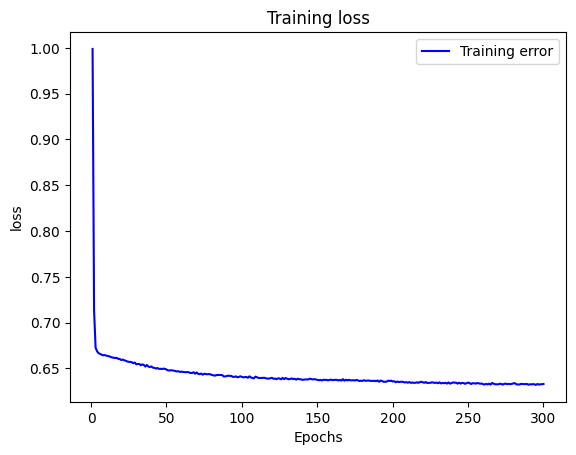

In [20]:
loss = history.history['loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'b', label='Training error')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()

plt.show()

Revisemos en el conjunto de test la medida del error.

In [21]:
predictions= model.predict(X_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [22]:
predictions.shape

(200, 1)

In [23]:
y_test.shape

(200,)

In [ ]:
df_y=pd.DataFrame(np.concatenate((predictions, y_test.reshape(-1,1)),axis=1), columns=['predictions','true'])

In [25]:
df_y

,predictions,true
0,0.335114,0.0
1,0.370879,1.0
2,0.603271,0.0
3,0.629149,1.0
4,0.550939,0.0
...,...,...
195,0.387448,1.0
196,0.650066,0.0
197,0.291612,0.0
198,0.575345,0.0


In [ ]:
df_y['predict_bin']=(df_y['predictions']>0.5).astype(int)

In [27]:
df_y

,predictions,true,predict_bin
0,0.335114,0.0,0
1,0.370879,1.0,0
2,0.603271,0.0,1
3,0.629149,1.0,1
4,0.550939,0.0,1
...,...,...,...
195,0.387448,1.0,0
196,0.650066,0.0,1
197,0.291612,0.0,0
198,0.575345,0.0,1


In [28]:
pd.value_counts(df_y['true'])

/tmp/ipykernel_16670/4151642742.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(df_y['true'])


true
1.0    108
0.0     92
Name: count, dtype: int64

In [29]:
confusion_matrix(df_y['true'].astype(int),df_y['predict_bin'])

array([[48, 44],
       [51, 57]])

53676/53676 ━━━━━━━━━━━━━━━━━━━━ 18s 327us/step
2228/2228 ━━━━━━━━━━━━━━━━━━━━ 1s 331us/step


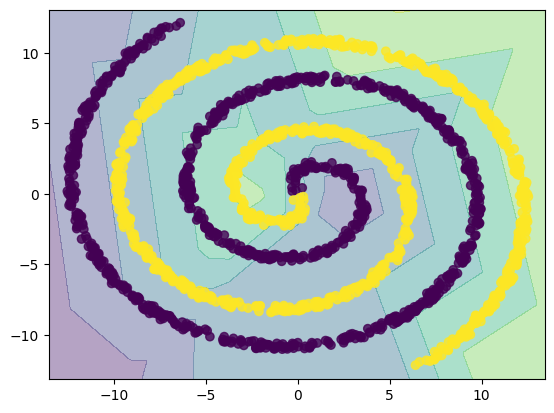

In [30]:
# Código tomado de https://github.com/tirthajyoti/Machine-Learning-with-Python/blob/master/Utilities/ML-Python-utils.py

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, m_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1
y_min, y_max = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1
# Meshgrid creation
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh using the model.
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                      np.arange(y_min, y_max, 0.1))

# Predictions to obtain the classification results
Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

# Plotting
plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.8)

### Callbacks

Desafortunadamente, la anterior gráfica no nos dice mucho acerca del performance del modelo en los datos de test y nos plantea las siguientes preguntas: ¿Cuántas épocas debemos utilizar?, ¿Será que con menos épocas se logra un mejor resultado, o faltan épocas?. Al utilizar métodos de momento y mini-batches para entrenar se puede obsevar que el error de entrenamiento aunque disminuye en el tiempo puede aumentar en una iteración. Y si estoy "de malas" y justo en el número de épocas suministrada el error sube, ¿estoy obteniendo el mejor modelo?

El conjunto de validación (val_df) se utiliza con el fin de poder seguir más de cerca el proceso de aprendizaje época a época y dar solución a este tipo de inquietudes. La idea es revisar al final de la época el performance del modelo con datos que la red no esta utilizando para disminuir la pérdida, con el fin de diagnosticar de mejor manera si estamos en un escenario de alta varianza o alto sesgo.  Este conjunto se puede configurar de 2 formas diferentes, utilizando los siguientes parámetros:



*   validation_split: Porcentaje de datos del conjunto de entrenamiento que se separa del conjunto de entrenamiento para validar métricas de error.
*   validation_data: Directamente el conjunto de datos si se separó con anterioridad.



In [31]:
# Construyamos de nuevo el modelo para revisar cómo progresa el entrenamiento en validación

model=keras.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(len(X_train[1]),)))
model.add(layers.Dense(1, activation='sigmoid'))
# También vamos a cambiar la tasa de aprendizaje del optimizador, para eso utilizo Adam con un lr diferentes
model.compile(optimizer=Adam(learning_rate=0.01),loss='binary_crossentropy',metrics=[keras.metrics.Accuracy()])
history = model.fit(x=X_train,y=y_train, epochs=300, batch_size=32, validation_data=(X_val, y_val))



Epoch 1/300


/usr/local/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0000e+00 - loss: 0.7911 - val_accuracy: 0.0000e+00 - val_loss: 0.6692
Epoch 2/300
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.6830 - val_accuracy: 0.0000e+00 - val_loss: 0.6726
Epoch 3/300
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.6703 - val_accuracy: 0.0000e+00 - val_loss: 0.6609
Epoch 4/300
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.6673 - val_accuracy: 0.0000e+00 - val_loss: 0.6826
Epoch 5/300
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.6668 - val_accuracy: 0.0000e+00 - val_loss: 0.6810
Epoch 6/300
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.6616 - val_accuracy: 0.0000e+00 - val_loss: 0.6742
Epoch 7/300
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.6564 - val_accuracy: 0.0000e+00 - val_loss: 0.6582
Epoch 8/300
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.00

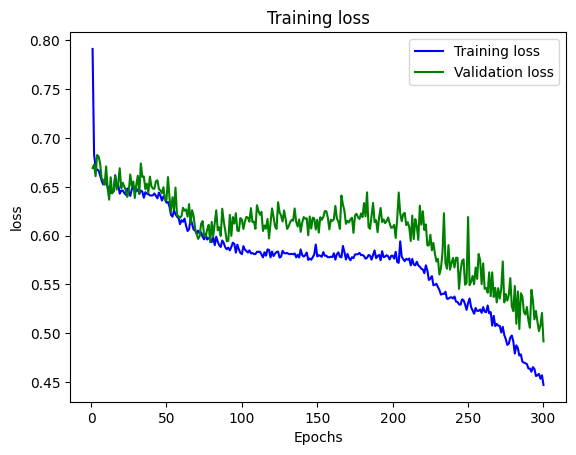

In [32]:
loss = history.history['loss']
val_loss= history.history['val_loss']
epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()

plt.show()

In [33]:
predictions= model.predict(X_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [ ]:
df_y=pd.DataFrame(np.concatenate((predictions, y_test.reshape(-1,1)),axis=1), columns=['predictions','true'])

In [35]:
df_y

,predictions,true
0,0.320067,0.0
1,0.429853,1.0
2,0.447261,0.0
3,0.614280,1.0
4,0.637340,0.0
...,...,...
195,0.347656,1.0
196,0.442922,0.0
197,0.000005,0.0
198,0.023789,0.0


In [ ]:
df_y['predict_bin'] = (df_y['predictions']>0.5).astype(int)

In [37]:
pd.value_counts(df_y['true'])

/tmp/ipykernel_16670/4151642742.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(df_y['true'])


true
1.0    108
0.0     92
Name: count, dtype: int64

In [38]:
confusion_matrix(df_y['true'].astype(int),df_y['predict_bin'])

array([[72, 20],
       [38, 70]])

La idea de manejar el proceso de aprendizaje es identificar la arquitectura (número de capas, número de neuronas por capa, y función de activación) adecuada para resolver el problema. Podemos probar varias configuraciones y escoger la que minimice el error de validación.

Antes de hacer esto, es importante aclarar que existen otros hiperparámetros importantes que afectan el error de la red y el proceso de aprendizaje:

* Tamaño del mini-batch  
* Tasa de aprendizaje del algoritmo de optimización
* Parámetros propios del algoritmo de optimización, por ejemplo en Adam el $\beta_1$ y $\beta_2$ que controlan la memoria de la velocidad y momento del algoritmo
* Regularización

Antes de cambiar estos hiperparámetros, estudiemos otras herramientas de Keras que nos permiten manejar de manera más adecuada el proceso de entrenamiento.

Los [callbacks](https://keras.io/api/callbacks/) son funciones que se ejecutan siempre al inicio o final de una época, y al final del proceso de entrenamiento. En el link anterior puede encontrar el modo de uso de estas funciones. Particularmente son importantes los siguientes callbacks:



*   [EarlyStopping](https://keras.io/api/callbacks/early_stopping/)
  El callback de EarlyStopping nos permite parar el algoritmo en el momento en el cuál el error de validación deja de mejorar, de tal forma que no tenemos que esperar todas las épocas ejecutadas inicialmente.

*   [ModelCheckpoint](https://keras.io/api/callbacks/model_checkpoint/)
  El callback de ModelCheckpoint nos permite guardar el mejor modelo visto época a época, de esta forma no nos quedamos con el modelo en el estado de la última época siempre.

Revisemos el uso de estos Callbacks, con el siguiente ejemplo

In [39]:
# Probemos un modelo con 2 capas de 4 unidades neuronales.

# Declaración callback de EarlyStopping (si pasan más de 10 épocas y no mejora el error de validación, se para la ejecución)
callback_early = EarlyStopping(monitor='val_loss', mode='min', patience=10)
# Declaración callback checkpoint ( se guarda en el directorio /tmp/checkpoints el modelo con el menor error)
callback_checkpoint = ModelCheckpoint(filepath='/tmp/checkpoints.keras',monitor='val_loss', mode='min',save_best_only=True)


model = keras.Sequential()
model.add(layers.Dense(4, activation='relu', input_shape=(len(X[1]),)))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer=Adam(learning_rate=0.01),loss='binary_crossentropy',metrics=[keras.metrics.Accuracy()])
# La función fit recibe los callbacks declarados
history = model.fit(x=X_train,y=y_train, epochs=300, batch_size=32, validation_data=(X_val, y_val),callbacks=[callback_early, callback_checkpoint])

Epoch 1/300


/usr/local/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0000e+00 - loss: 0.9318 - val_accuracy: 0.0000e+00 - val_loss: 0.7047
Epoch 2/300
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.6801 - val_accuracy: 0.0000e+00 - val_loss: 0.6761
Epoch 3/300
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.6697 - val_accuracy: 0.0000e+00 - val_loss: 0.6796
Epoch 4/300
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.6674 - val_accuracy: 0.0000e+00 - val_loss: 0.6777
Epoch 5/300
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.6662 - val_accuracy: 0.0000e+00 - val_loss: 0.6704
Epoch 6/300
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.6655 - val_accuracy: 0.0000e+00 - val_loss: 0.6675
Epoch 7/300
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.6671 - val_accuracy: 0.0000e+00 - val_loss: 0.6689
Epoch 8/300
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.00

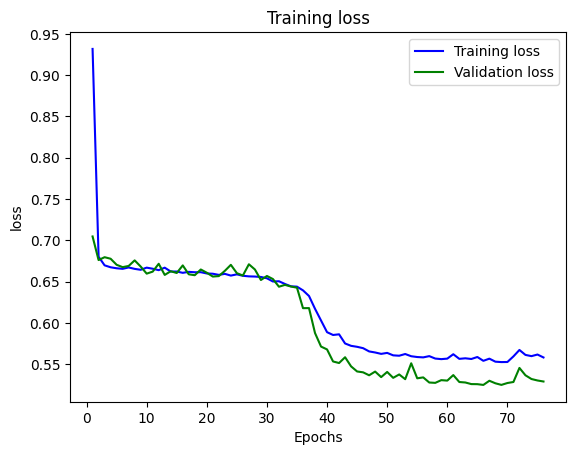

In [40]:
loss = history.history['loss']
val_loss= history.history['val_loss']
epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()

plt.show()

In [41]:
# No olvidar recargar  modelo los mejores pesos encontrados
model.load_weights('/tmp/checkpoints.keras')

In [42]:
predictions= model.predict(X_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [43]:
predictions.shape

(200, 1)

In [44]:
y_test.shape

(200,)

In [ ]:
df_y=pd.DataFrame(np.concatenate((predictions, y_test.reshape(-1,1)),axis=1), columns=['predictions','true'])

In [46]:
df_y

,predictions,true
0,0.025944,0.0
1,0.607604,1.0
2,0.607604,0.0
3,0.607604,1.0
4,0.607604,0.0
...,...,...
195,0.607604,1.0
196,0.607604,0.0
197,0.004163,0.0
198,0.607604,0.0


In [ ]:
df_y['predict_bin']=(df_y['predictions']>0.5).astype(int)

In [48]:
df_y

,predictions,true,predict_bin
0,0.025944,0.0,0
1,0.607604,1.0,1
2,0.607604,0.0,1
3,0.607604,1.0,1
4,0.607604,0.0,1
...,...,...,...
195,0.607604,1.0,1
196,0.607604,0.0,1
197,0.004163,0.0,0
198,0.607604,0.0,1


In [49]:
pd.value_counts(df_y['true'])

/tmp/ipykernel_16670/4151642742.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(df_y['true'])


true
1.0    108
0.0     92
Name: count, dtype: int64

In [50]:
confusion_matrix(df_y['true'].astype(int),df_y['predict_bin'])

array([[ 35,  57],
       [  0, 108]])

53676/53676 ━━━━━━━━━━━━━━━━━━━━ 19s 352us/step
2228/2228 ━━━━━━━━━━━━━━━━━━━━ 1s 373us/step


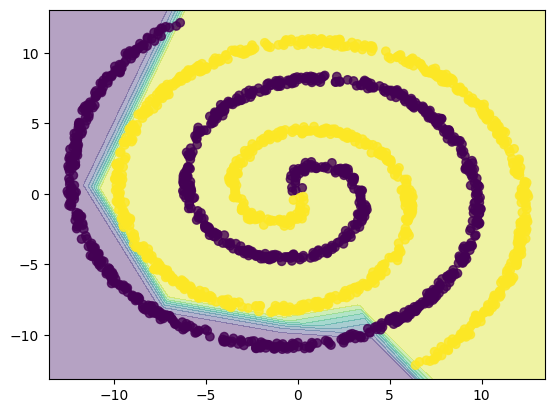

In [51]:
# Código tomado de https://github.com/tirthajyoti/Machine-Learning-with-Python/blob/master/Utilities/ML-Python-utils.py

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, m_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1
y_min, y_max = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1
# Meshgrid creation
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh using the model.
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                      np.arange(y_min, y_max, 0.1))

# Predictions to obtain the classification results
Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

# Plotting
plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.8)

## Punto 1 (20%)

Esta red aún no presenta un buen comportamiento en el conjunto de datos. Explore los hiperparámetros de la red para realizar una clasificación adecuada, mida el performance utilizando métricas de clasificación. Justifique los pasos que lo llevaron a escoger el modelo utilizando las curvas del proceso de aprendizaje. Grafique las fronteras de decisión encontradas.

In [52]:
X_train.shape

(1600, 2)

In [53]:
# Probemos un modelo con 2 capas de 4 unidades neuronales.

# Declaración callback de EarlyStopping (si pasan más de 10 épocas y no mejora el error de validación, se para la ejecución)
callback_early = EarlyStopping(monitor='val_loss', mode='min', patience=10)
# Declaración callback checkpoint ( se guarda en el directorio /tmp/checkpoints el modelo con el menor error)
callback_checkpoint = ModelCheckpoint(filepath='/tmp/checkpoints.keras',monitor='val_loss', mode='min',save_best_only=True)


model = keras.Sequential()
model.add(layers.Dense(32, activation='relu', input_shape=(len(X[1]),)))
model.add(layers.Dense(32, activation='relu', input_shape=(len(X[1]),)))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer=Adam(learning_rate=0.01),loss='binary_crossentropy',metrics=[keras.metrics.Accuracy()])
# La función fit recibe los callbacks declarados
history = model.fit(x=X_train,y=y_train, epochs=300, batch_size=32, validation_data=(X_val, y_val),callbacks=[callback_early, callback_checkpoint])

Epoch 1/300


/usr/local/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0000e+00 - loss: 0.7076 - val_accuracy: 0.0000e+00 - val_loss: 0.6664
Epoch 2/300
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.6757 - val_accuracy: 0.0000e+00 - val_loss: 0.6611
Epoch 3/300
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.6631 - val_accuracy: 0.0000e+00 - val_loss: 0.6664
Epoch 4/300
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.6615 - val_accuracy: 0.0000e+00 - val_loss: 0.6598
Epoch 5/300
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.6533 - val_accuracy: 0.0000e+00 - val_loss: 0.6546
Epoch 6/300
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.6584 - val_accuracy: 0.0000e+00 - val_loss: 0.6530
Epoch 7/300
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.6529 - val_accuracy: 0.0000e+00 - val_loss: 0.6487
Epoch 8/300
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.00

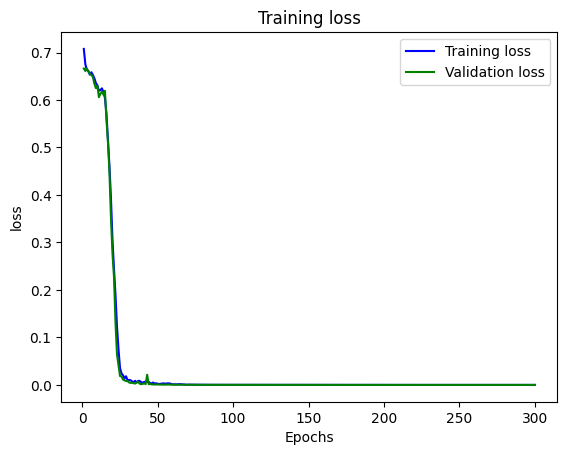

In [54]:
loss = history.history['loss']
val_loss= history.history['val_loss']
epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()

plt.show()

In [55]:
predictions= model.predict(X_val)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [56]:
df_y=pd.DataFrame(np.concatenate((predictions, y_val.reshape(-1,1)),axis=1), columns=['predictions','true'])
df_y['predict_bin']=(df_y['predictions']>0.5).astype(int)
df_y


,predictions,true,predict_bin
0,9.999996e-01,1.0,1
1,1.843210e-07,0.0,0
2,9.999995e-01,1.0,1
3,7.677489e-10,0.0,0
4,2.734658e-07,0.0,0
...,...,...,...
195,2.435932e-07,0.0,0
196,1.500049e-06,0.0,0
197,9.999998e-01,1.0,1
198,9.999996e-01,1.0,1


In [57]:
confusion_matrix(df_y['true'].astype(int),df_y['predict_bin'])

array([[107,   0],
       [  0,  93]])

50171/50171 ━━━━━━━━━━━━━━━━━━━━ 17s 348us/step
2228/2228 ━━━━━━━━━━━━━━━━━━━━ 1s 384us/step


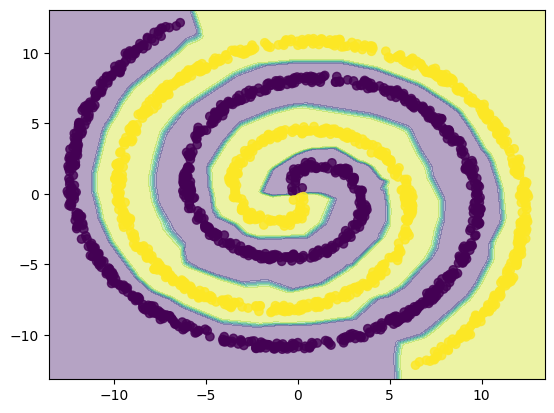

In [58]:
# Código tomado de https://github.com/tirthajyoti/Machine-Learning-with-Python/blob/master/Utilities/ML-Python-utils.py

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, m_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = X_val[:, 0].min() - 1, X_val[:, 0].max() + 1
y_min, y_max = X_val[:, 1].min() - 1, X_val[:, 1].max() + 1
# Meshgrid creation
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh using the model.
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                      np.arange(y_min, y_max, 0.1))

# Predictions to obtain the classification results
Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

# Plotting
plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.8)